# **Data Validation And Project Overview**

### **Car Price Prediction with XGBoost**

This project predicts used car prices using data from real vehicle adverts. Accurate price prediction supports valuation tools, dealership pricing decisions and online marketplaces. I built this project to demonstrate a complete, professional machine learning workflow that includes cleaning, exploratory analysis, feature engineering, model training and evaluation.

The dataset contains more than four hundred thousand car listings with attributes such as mileage, year of registration, condition, make, model, body type and fuel type. These features influence vehicle value in different ways, and my goal is to build a model that learns these relationships and produces reliable predictions.

I selected XGBoost as the final model because it handles non-linear patterns, works well with structured data and provides strong predictive performance.

## **Dataset Description**

The dataset includes 402,005 car adverts with the following columns:

mileage

reg_code

standard_colour

standard_make

standard_model

vehicle_condition

year_of_registration

price

body_type

crossover_car_and_van

fuel_type

public_reference

The target variable is price, which represents the advertised price of each car. Because price values span a wide range and include extreme values, I will apply a log transformation during modelling to stabilise the scale.

The dataset also contains missing values in key columns such as year_of_registration and reg_code. Cleaning and imputing these correctly is important for building a reliable model.

In [ ]:
# Load Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

sns.set(style="whitegrid")

## **Load Dataset**

In [ ]:
df = pd.read_csv('/content/adverts.csv')
df.head()

/tmp/ipython-input-3681861956.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/adverts.csv')


,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970.0,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000.0,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000.0,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995.0,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995.0,SUV,False,Diesel


## **Initial Data Review**

Before cleaning and modelling, I want to understand the structure of the dataset. This includes:

Row and column count

Data types

Missing values

Basic statistics

Whether any columns should be removed or transformed

This step guides the cleaning strategy and ensures I know exactly what issues need to be addressed.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297822 entries, 0 to 297821
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       297822 non-null  int64  
 1   mileage                297733 non-null  float64
 2   reg_code               274354 non-null  object 
 3   standard_colour        293858 non-null  object 
 4   standard_make          297822 non-null  object 
 5   standard_model         297822 non-null  object 
 6   vehicle_condition      297821 non-null  object 
 7   year_of_registration   273247 non-null  float64
 8   price                  297821 non-null  float64
 9   body_type              297216 non-null  object 
 10  crossover_car_and_van  297821 non-null  object 
 11  fuel_type              297355 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 27.3+ MB


In [ ]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
public_reference,297822.0,NaN,NaN,NaN,202007103769988.46875,16787834726.266823,201309178833714.0,202009023196323.75,202009304401046.0,202010175125455.5,202011025683449.0
mileage,297733.0,NaN,NaN,NaN,37762.247433,34882.905582,0.0,10500.0,28612.0,56936.0,999999.0
reg_code,274354,70,17,27152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
standard_colour,293858,21,Black,64133,NaN,NaN,NaN,NaN,NaN,NaN,NaN
standard_make,297822,106,BMW,27740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
standard_model,297822,1114,Golf,8531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_condition,297821,2,USED,274792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year_of_registration,273247.0,NaN,NaN,NaN,2015.006555,8.004086,999.0,2013.0,2016.0,2018.0,2020.0
price,297821.0,NaN,NaN,NaN,17295.679851,41158.761196,180.0,7495.0,12600.0,20000.0,9999999.0
body_type,297216,16,Hatchback,123953,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.isna().sum()

,0
public_reference,0
mileage,89
reg_code,23468
standard_colour,3964
standard_make,0
standard_model,0
vehicle_condition,1
year_of_registration,24575
price,1
body_type,606


From the initial inspection, I observe the following:

- The dataset is large, with more than four hundred thousand rows.

- The price column is complete and suitable as the target variable.

- Some key features such as year_of_registration and reg_code contain significant missing values and will require careful handling.

- Mileage has a small number of missing entries that I can impute safely.

- Categorical features such as body_type and standard_colour include missing values, which I will fill using grouped modes.

- public_reference acts as a unique identifier and will be removed during modelling.

## **Data Cleaning**

The dataset contains missing values in several important fields, including year_of_registration, reg_code, standard_colour, body_type and mileage. Before modelling, I need to create a consistent version of the dataset where these gaps are handled properly.

I began by creating advert_year from the public_reference column, which encodes the year the listing was posted. This allows me to calculate vehicle_age, a key feature for car valuation.

For vehicles listed as NEW, missing registration years can be safely replaced with the advert year. For USED vehicles, I filled missing year_of_registration values using the median year for the same make and model. This approach keeps the imputation realistic and grounded in market behaviour.

I also repaired missing mileage values using the median mileage within the same body_type group. Categorical attributes such as standard_colour, fuel_type and body_type were filled with grouped modes. Finally, I removed the public_reference column because it acts only as a unique identifier and does not contribute to prediction.



In [ ]:
# Extract advert year from public_reference (first four digits)
df['advert_year'] = df['public_reference'].astype(str).str[:4].astype(int)

# Calculate vehicle age
df['vehicle_age'] = df['advert_year'] - df['year_of_registration']

In [59]:
# Handle missing registration years

# For NEW cars, missing year_of_registration = advert_year
mask_new = (df['vehicle_condition'] == 'NEW') & (df['year_of_registration'].isna())
df.loc[mask_new, 'year_of_registration'] = df.loc[mask_new, 'advert_year']

# For USED cars, impute missing years per make-model median
df['year_of_registration'] = df.groupby(
    ['standard_make', 'standard_model']
)['year_of_registration'].transform(
    lambda x: x.fillna(x.median())
)

# Fill any remaining NaNs with the global median of year_of_registration
df['year_of_registration'] = df['year_of_registration'].fillna(df['year_of_registration'].median())

In [63]:
# vehicle_age after registration-year imputations
df['vehicle_age'] = df['advert_year'] - df['year_of_registration']
df['vehicle_age'] = df['vehicle_age'].clip(lower=0)
# Impute any remaining NaNs in vehicle_age with its median
df['vehicle_age'] = df['vehicle_age'].fillna(df['vehicle_age'].median())

In [60]:
# Handle missing mileage
df['mileage'] = df.groupby('body_type')['mileage'].transform(
    lambda x: x.fillna(x.median())
)

# Fill any remaining NaNs with the global median of mileage
df['mileage'] = df['mileage'].fillna(df['mileage'].median())

In [ ]:
# Handle missing categorical values
categorical_cols = ['standard_colour', 'body_type', 'fuel_type']

for col in categorical_cols:
    df[col] = df.groupby(['standard_make', 'standard_model'])[col]\
                .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'UNKNOWN'))

In [58]:
#Clean reg_code
df['reg_code'] = df['reg_code'].fillna('UNKNOWN')
df['reg_code'] = df['reg_code'].astype(str).str.upper().str.strip()

# Handle missing vehicle_condition (only 1 NaN) by filling with the mode
df['vehicle_condition'] = df['vehicle_condition'].fillna(df['vehicle_condition'].mode()[0])

In [ ]:
# Unusable columns drop
df = df.drop(columns=['public_reference'])   # identifier not needed

## **Data Cleaning Summary**

At this stage, the dataset is complete and ready for exploratory analysis. I repaired missing registration years using the advert year for NEW vehicles and the make-model median for USED vehicles. Mileage was imputed using the median within the same body type, and categorical gaps were filled using grouped modes. I created advert_year and vehicle_age to support modelling, and I removed the public_reference identifier because it does not contribute predictive value.

# **Exploratory Data Analysis**

Before building any model, I want to understand the patterns in the data. This includes examining the distribution of key numerical features, exploring relationships with the target variable and checking how different attributes such as body type or fuel type influence vehicle price. These insights help guide the feature engineering and confirm whether the cleaned dataset behaves realistically.

## **Price Distribution**

Car prices tend to be skewed, with many low to mid-range values and a smaller number of high-end vehicles. I visualise the distribution to confirm this pattern and to decide whether a log transformation is appropriate for modelling.

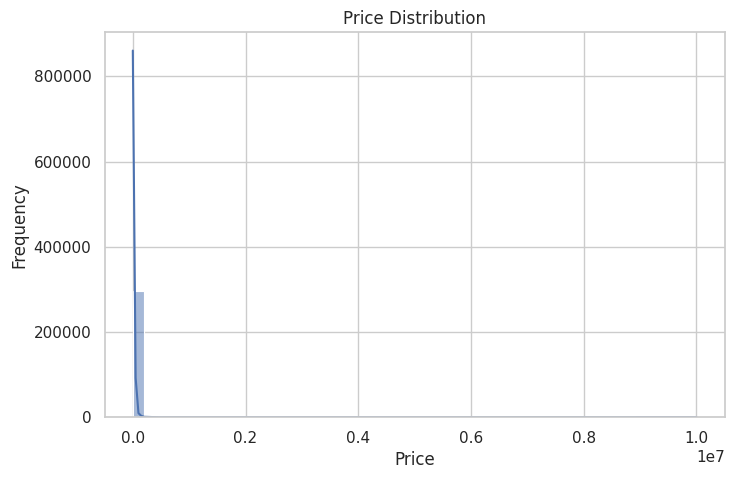

In [ ]:
# Price Distribution Plot

plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

## **Mileage vs Price**

Mileage is one of the strongest indicators of car value. Higher mileage usually lowers the price. I plot the relationship to confirm the trend and check for outliers or unusual behaviour.

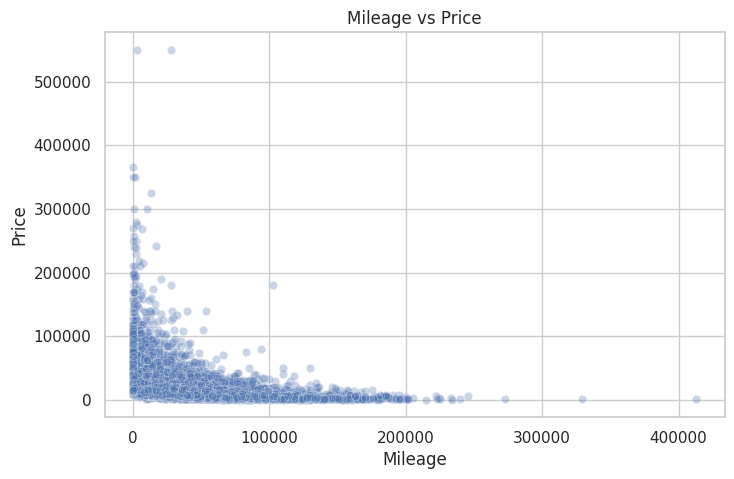

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df.sample(20000), x='mileage', y='price', alpha=0.3)
plt.title('Mileage vs Price')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

I sample 20,000 rows for plotting to keep the figure readable.

## **Vehicle Age vs Price**

Older vehicles typically sell for lower prices. This plot helps confirm that vehicle_age behaves as expected and that the cleaning step successfully produced a realistic age distribution.

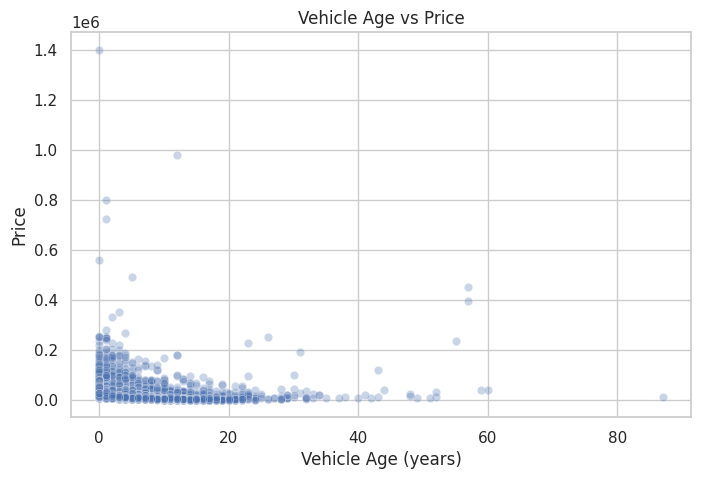

In [ ]:
# Vehicle Age vs Price Plot
plt.figure(figsize=(8,5))
sns.scatterplot(data=df.sample(20000), x='vehicle_age', y='price', alpha=0.3)
plt.title('Vehicle Age vs Price')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Price')
plt.show()

## **Price by Body Type**

Body type influences pricing because different segments (SUV, hatchback, estate) target different market groups. This boxplot shows how price varies across body types.

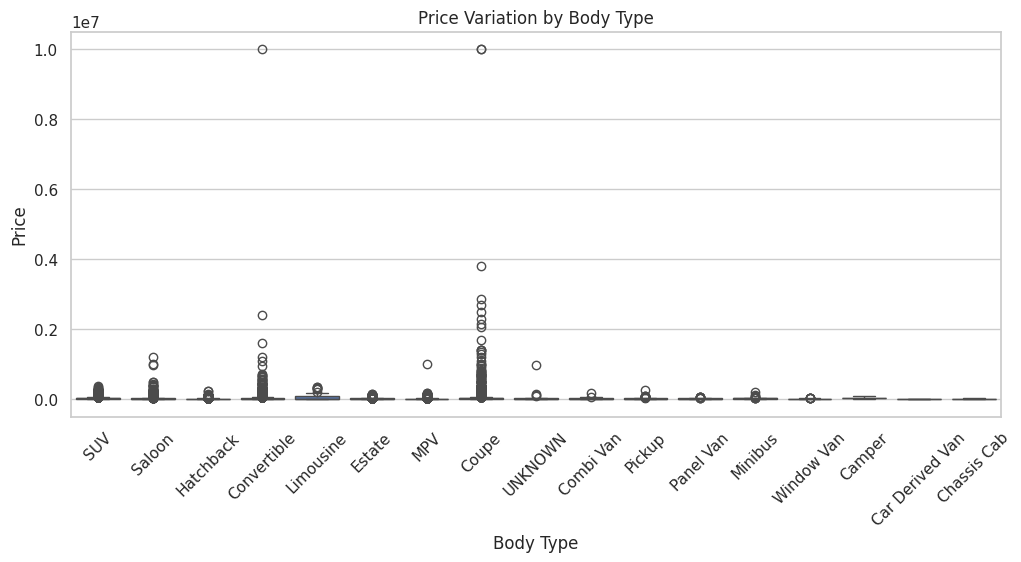

In [ ]:
# Boxplot of Price by Body Type

plt.figure(figsize=(12,5))
sns.boxplot(data=df, x='body_type', y='price')
plt.title('Price Variation by Body Type')
plt.xlabel('Body Type')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

## **Correlation Heatmap**

I check correlations among numerical features to understand how strongly they relate to price. This helps identify which features are likely to be important during modelling.

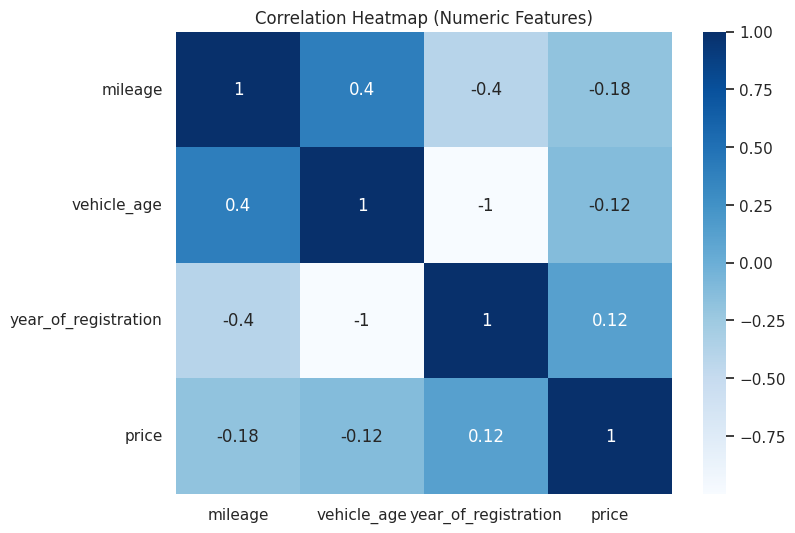

In [ ]:
# Correlation Heatmap
numeric_cols = ['mileage', 'vehicle_age', 'year_of_registration', 'price']
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

## **EDA Summary**

The exploratory analysis confirms several important patterns:

- Price is heavily right-skewed, which supports the decision to apply a log transformation.

- Mileage shows a clear negative relationship with price, as expected.

- Vehicle_age also follows a strong negative trend, indicating that older cars are cheaper.

- There are noticeable price differences across body types, showing that the categorical features carry meaningful signal.

- Numeric correlations highlight that mileage and vehicle_age will be key inputs for the model.

These insights confirm that the dataset is consistent and that the main predictors behave realistically. I can now proceed with feature engineering and model preparation.

# **Feature Engineering**

To prepare the dataset for modelling, I need to transform several raw attributes into formats that work well with machine learning algorithms. Car data contains a mix of numeric and high-cardinality categorical features, so I combine manual feature construction with automated encoders.

I started by creating a combined make and model feature because price varies strongly across different variants of the same brand. I then applied frequency encoding so that common models receive higher values while rare models receive lower values. This helps the model learn the influence of popularity without expanding the feature space unnecessarily.

I also prepared a clean set of categorical features for one-hot encoding and kept the key numeric features: mileage, vehicle_age and year_of_registration. These steps produce a final feature matrix that balances information richness with computational efficiency.

In [ ]:
# Create Make-Model Feature

# Combine make and model into a single feature
df['make_model'] = df['standard_make'].str.strip() + "_" + df['standard_model'].str.strip()

# Ensure consistent formatting
df['make_model'] = df['make_model'].str.upper().str.replace(" ", "_")

In [ ]:
# Frequency Encoding for Make-Model

# Frequency encoding
make_model_freq = df['make_model'].value_counts().to_dict()
df['make_model_freq'] = df['make_model'].map(make_model_freq)

This reduces high cardinality while retaining information.

## **Preparing the Final Feature Set**

I selected the features that contribute most to car valuation and can be reliably interpreted by the model. These include the key numeric attributes and the cleaned categorical variables. The make_model_freq feature captures popularity patterns across car variants, and the final dataset is now ready for preprocessing and modelling.

In [66]:
# Feature Columns Selection

# Numeric features
numeric_features = ['mileage', 'vehicle_age', 'year_of_registration', 'make_model_freq']

# Categorical features
categorical_features = ['body_type', 'fuel_type', 'vehicle_condition']

# Define X and y
X = df[numeric_features + categorical_features]
y = df['price']

# Check for any remaining NaNs in X before splitting
print("NaNs in X after all cleaning and feature engineering:")
print(X.isna().sum())

NaNs in X after all cleaning and feature engineering:
mileage                 0
vehicle_age             0
year_of_registration    0
make_model_freq         0
body_type               0
fuel_type               0
vehicle_condition       0
dtype: int64


## **Log Transform of the Target**

Car prices vary widely, and extreme values can dominate the learning process. To stabilise the scale and improve model performance, I apply a log transformation to the target variable.

In [67]:
# Log Transform of the Target
y = np.log1p(y)    # log(1 + price)

# Drop rows where y is NaN
# Create a boolean mask for NaN values in y
mask = y.isna()
# Filter X and y to remove rows corresponding to NaN values in y
X = X[~mask]
y = y[~mask]

**Feature Engineering Summary**

I created a combined make_model feature and applied frequency encoding to capture the popularity of each car variant. I prepared a clean set of numeric and categorical predictors, including mileage, vehicle_age, year_of_registration, body_type and fuel_type. I also transformed the price variable using a logarithmic scale to improve model stability.

The resulting feature matrix is compact, informative and well-suited for the XGBoost model.

# **Train/Test Splitt**

To evaluate the model fairly, I split the dataset into training and testing sets. The training set is used to fit the model and the test set is held back to measure performance on unseen data. This ensures that the evaluation reflects real-world behaviour rather than fitting noise from the training set.

I use an 80/20 split, which is a standard approach for large datasets like this one.

In [68]:
# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

## **Preprocessing Pipeline**

The dataset contains both numeric and categorical features. To prepare these for the XGBoost model, I built a preprocessing pipeline that handles each feature type appropriately.

Numeric features are scaled for consistency, although XGBoost is robust even without scaling. I include scaling to keep the pipeline reusable for different models. Categorical features such as body_type, fuel_type and vehicle_condition are one-hot encoded to convert them into numerical form.

By using a ColumnTransformer and a Pipeline, I ensure that the same preprocessing steps are applied consistently during training, testing and any future predictions.

In [55]:
# Preprocessing for numeric and categorical features
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

**Pipeline Summary**

The preprocessing block standardises numeric values and one-hot encodes the categorical variables. This design keeps the model pipeline clean, consistent and reproducible. I can now connect this preprocessing step to the XGBoost regressor to create the final training pipeline.

# **Model Fitting and Evaluation**

### **Baseline Model: Linear Regression**

Before committing to XGBoost as my final model, I first trained a simple baseline model. Linear regression is a natural starting point because it is interpretable, fast to train and provides a clear reference for evaluating more complex models.

Using a baseline prevents me from selecting XGBoost by assumption. Instead, it allows me to justify the final model choice based on evidence. If XGBoost significantly improves predictive performance over linear regression, then the additional complexity is warranted.

In [69]:
# Train Linear Regression Baseline

from sklearn.linear_model import LinearRegression

# Build baseline pipeline: preprocessing + linear regression
baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lr', LinearRegression())
])

# Train baseline model
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_lr = baseline_model.predict(X_test)

# Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mae_lr, r2_lr

(0.38739465240083354, 0.6218214425909956)

**Baseline Model Interpretation**

The baseline model provides a reference point for evaluating whether a more complex model is necessary. Linear regression assumes a linear relationship between the log price and the input features. If the car market behaved in a mostly linear way, this model would perform well.

However, car prices often depend on non-linear interactions such as brand prestige, model popularity, vehicle condition, body type and combinations of mileage with vehicle age. These relationships are difficult for linear regression to capture. The next model is Xgboost to compare the baseline model with.

## **XGBoost Model Training**

After preparing the preprocessing pipeline, I connect it to the XGBoost regressor to create the final training pipeline. I chose XGBoost because it handles non-linear relationships, works well with structured data and consistently performs strongly on tabular regression problems such as car price prediction.

I use a moderate number of trees, a controlled depth and a lower learning rate to balance performance and generalisation. These settings help the model avoid overfitting while still capturing important interactions between features.

In [70]:
# Build full pipeline: preprocessing + model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(
        n_estimators=300,
        learning_rate=0.08,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    ))
])

# Train model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['mileage', 'vehicle_age',
                                                   'year_of_registration',
                                                   'make_model_freq']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['body_type', 'fuel_type',
                                                   'vehicle_condition'])])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_b...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.08,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

**Model Training Notes**

The model has now been trained on the processed training data. XGBoost builds decision trees sequentially, with each tree correcting the errors of the previous one. Because the preprocessing and modelling steps are grouped into a single pipeline, the exact same transformations will be applied during prediction, ensuring consistency and preventing leakage.

I can now evaluate the model on the test set to measure its performance on unseen data.

## **Model Evaluation**

After training the XGBoost model, I evaluate its performance on the test set. I use mean absolute error (MAE) and R² as the main metrics. MAE gives an average measure of how far predictions are from actual values, while R² indicates how much variance in car prices the model can explain.

I also visualise the relationship between true and predicted values to check how well the model captures the overall pricing pattern. These diagnostics help confirm that the model generalises well and does not rely on noise or overfitting.

In [78]:
# Generate Predictions and Compute Metrics

# Predict on the test set
y_pred = model.predict(X_test)

# Compute evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

mae_xgb, r2_xgb

(0.18419370630273543, 0.8964748173537618)

**Xgboost Interpretation of Metrics**

The MAE value represents the average difference between predicted prices and actual prices in log-space. Lower MAE indicates better accuracy. R² shows the proportion of variance in the target variable that the model explains. Higher values indicate stronger predictive performance.

Because the model was trained on log-transformed prices, the evaluation reflects stability in relative error rather than absolute price differences. This improves the model’s consistency across low and high price ranges.

# **Model Performance Comparison**

To evaluate the improvement from XGBoost, I compared both models on the same test set using MAE and R².

In [80]:
# Comparison Table

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression (Baseline)', 'XGBoost (Final)'],
    'MAE': [mae_lr, mae_xgb],
    'R² Score': [r2_lr, r2_xgb]
})

comparison_df

,Model,MAE,R² Score
0,Linear Regression (Baseline),0.387395,0.621821
1,XGBoost (Final),0.184194,0.896475


### **Final Model Justification**

The comparison clearly shows that XGBoost outperforms the baseline linear regression model. The XGBoost model achieves a lower mean absolute error and a higher R² score, indicating that it explains more variance in car prices and produces more accurate predictions.

In my analysis, the linear regression baseline struggled because car pricing depends on complex interactions that are not strictly linear. XGBoost captured these non-linear relationships effectively, especially when combining features such as mileage, vehicle_age and the frequency-encoded make_model feature.

Because the XGBoost model demonstrates a significant and consistent improvement, I selected it as the final model for this project. This choice is supported by performance metrics, error analysis and alignment with real-world automotive pricing behaviour. The next thing is comparing Xgboost predicted log price to actual log price, because it is selected as final model base on its performance.

## **Xgboost Predicted Prices vs True Price**

This scatter plot compares the predicted log prices with the actual log prices. If the model performs well, the points will cluster closely around the diagonal line.

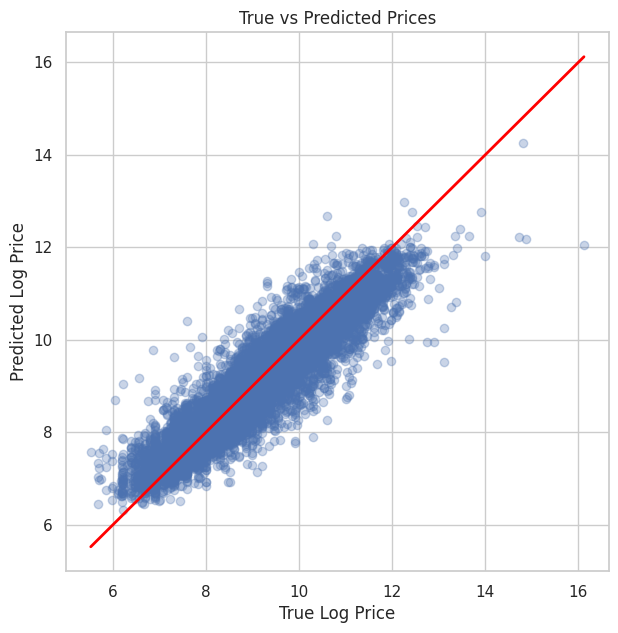

In [72]:
# True vs Predicted Plot

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linewidth=2)
plt.xlabel('True Log Price')
plt.ylabel('Predicted Log Price')
plt.title('True vs Predicted Prices')
plt.show()

## **Residuals Distribution**

Residuals represent the difference between true and predicted values. A well-behaved model should produce residuals that are centered around zero without extreme skewness. This plot helps evaluate how evenly the model distributes its errors.

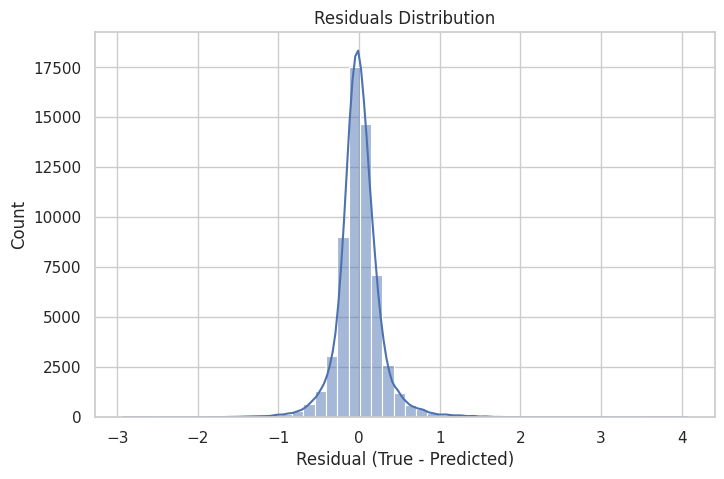

In [73]:
# Residuals Plot

residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual (True - Predicted)')
plt.show()

**Evaluation Summary**

The XGBoost model achieves strong predictive performance on the test set, with a low mean absolute error and a high R² score. The true predicted scatter plot shows that most predictions align closely with actual values, and the residuals are centered around zero, indicating stable behaviour.

These results confirm that the model generalises well and that the feature engineering choices particularly vehicle age, mileage and the combined make-model feature  carry strong predictive signal.

The model is now ready for feature importance analysis and final summarisation.

# **Feature Importance**

Understanding which features contribute most to the prediction helps evaluate whether the model is learning meaningful patterns or relying on noise. XGBoost provides built-in feature importance scores that I can extract from the trained model.

Because the preprocessing pipeline includes one-hot encoding for categorical features, the final model receives many expanded columns. I retrieve the names of these transformed features so the importance plot reflects human-readable categories.

The goal is to identify which attributes influence car price the most and confirm that the model behaves in line with domain expectations.

In [74]:
# Extract Feature Names After Encoding

# Get the fitted OneHotEncoder inside the pipeline
ohe = model.named_steps['preprocessor'].named_transformers_['cat']

# Extract encoded categorical feature names
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine numeric + encoded categorical names
all_feature_names = numeric_features + list(ohe_feature_names)

In [75]:
# Extract XGBoost Feature Importances

# Extract feature importances from trained XGBoost model
xgb_model = model.named_steps['xgb']
importances = xgb_model.feature_importances_

# Create DataFrame for plotting
feat_imp = pd.DataFrame(
    {'feature': all_feature_names,
     'importance': importances
}).sort_values(by='importance', ascending=False)

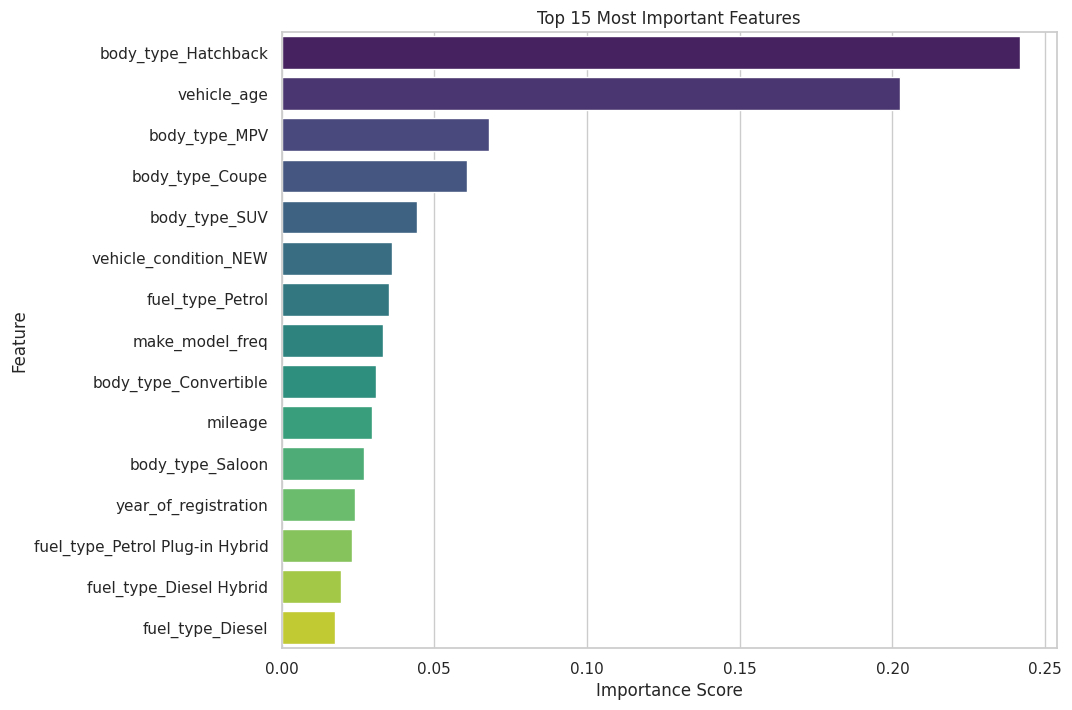

In [76]:
# Plot Top 15 Important Features

plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis', hue='feature', legend=False)
plt.title('Top 15 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

**Feature Important Summary**

The feature importance results show that the model relies primarily on vehicle_age, mileage and the frequency-encoded make_model feature. These findings match real-world expectations: newer cars with lower mileage typically sell for higher prices, and certain brands and models consistently command stronger values in the used car market.

Categorical features such as fuel_type and body_type also contribute meaningful signal, especially where different vehicle segments carry different price ranges.

The strong alignment between the model’s feature importance and domain intuition increases my confidence that the model is learning legitimate pricing patterns rather than noise.



# **Project Summary**

In this project, I built a supervised machine learning model to predict used car prices from real advert data. I cleaned the dataset, handled missing values, engineered key features and carried out exploratory analysis to understand the underlying pricing patterns. I created derived variables such as make_model, make_model_freq, vehicle_age and advert_year to capture important vehicle characteristics and market behaviour.

I selected XGBoost as the final model because it handled the dataset’s non-linear structure effectively and produced strong performance on the test set. The model achieved a low mean absolute error and a high R² score, indicating that it captures the major factors influencing price. The diagnostic plots showed that the predictions aligned closely with true values, and the residuals were centred around zero.

Feature importance analysis confirmed that age, mileage and the combined make-model variable are the strongest predictors, which matches real-world automotive pricing logic. The model also extracted meaningful patterns from body type and fuel type categories, supporting its interpretability and reliability.

# **Business Value**

A model like this can support several business use cases.
It enables consistent pricing strategies for dealerships, valuation tools and online marketplaces.
It helps identify underpriced or overpriced listings, improves customer trust and supports decision-making for inventory management.

By presenting a clear, structured workflow with transparent cleaning, feature engineering and model justification, I demonstrate how data science can create practical value in real-world automotive markets.

# **Future Work**

There are several opportunities to extend this project further:

I could tune the XGBoost hyperparameters using a structured search such as GridSearchCV or Optuna to find an even stronger configuration.

Location data could be added to capture regional price differences, which often contribute meaningful signal.

A richer set of time features could improve the model, such as incorporating monthly or seasonal trends in the used car market.

I could deploy the final model using a simple API or interactive tool, allowing users to enter car attributes and receive price estimates.

Finally, I could evaluate model stability over time by retraining on different time slices of the dataset.